In [63]:
#Import all relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#EDA taken from: https://medium.com/@siglimumuni/market-basket-analysis-in-python-an-implementation-with-online-retail-data-d565c47ae7ae

In [64]:

#Load the file into pandas
df = pd.read_excel("http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")

#check first 5 rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [66]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [67]:
#Drop all rows with a null value
df.dropna(inplace=True)
len(df)

406829

In [68]:
#Convert the InvoiceNo column to string
df["InvoiceNo"] = df["InvoiceNo"].astype('str')

#Remove rows with invoices that contain a "C"
df = df[~df["InvoiceNo"].str.contains("C")]

len(df)

397924

In [69]:
#Check the distribution of transactions per country
top10 = df["Country"].value_counts().head(10)
print(top10)

Country
United Kingdom    354345
Germany             9042
France              8342
EIRE                7238
Spain               2485
Netherlands         2363
Belgium             2031
Switzerland         1842
Portugal            1462
Australia           1185
Name: count, dtype: int64


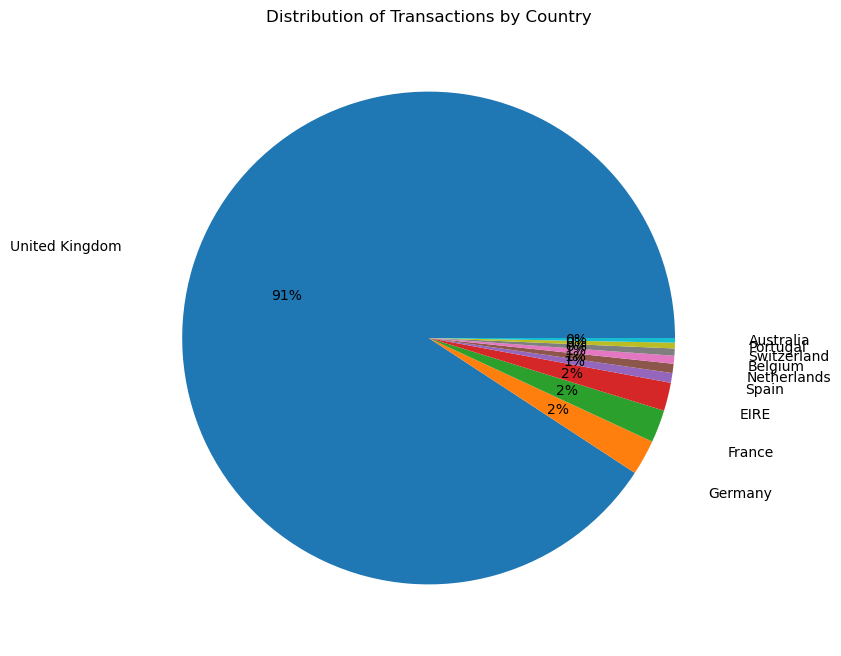

In [70]:
#Create a pie chart to show distribution of transactions
plt.figure(figsize=[8,8])
plt.pie(top10,labels=top10.index, autopct = '%0.0f%%',labeldistance=1.3)
plt.title("Distribution of Transactions by Country")
plt.show()

In [71]:
#Group, sum, unstack and set index of dataframe
basket = df[df['Country'] =="United Kingdom"]\
        .groupby(['InvoiceNo', 'Description'])["Quantity"]\
        .sum().unstack()\
        .reset_index().fillna(0)\
        .set_index("InvoiceNo")

basket.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
#Create function to hot encode the values
def encode_values(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

#Apply function to data
basket_encoded = basket.applymap(encode_values)

basket_encoded

C:\Users\domin\AppData\Local\Temp\ipykernel_46480\2614825591.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_encoded = basket.applymap(encode_values)


Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
#filter for only invoices with 2 or more items
basket_filtered = basket_encoded[(basket_encoded > 0).sum(axis=1) >= 2]

basket_filtered = basket_filtered.astype(bool)
basket_filtered.head()


Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536366,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536367,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536368,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536372,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Get number of invoices (index) and items (columns)

In [74]:
basket_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15376 entries, 536365 to 581586
Columns: 3844 entries,  4 PURPLE FLOCK DINNER CANDLES to ZINC WIRE SWEETHEART LETTER TRAY
dtypes: bool(3844)
memory usage: 56.5+ MB


In [75]:
basket_filtered.describe()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
count,15376,15376,15376,15376,15376,15376,15376,15376,15376,15376,...,15376,15376,15376,15376,15376,15376,15376,15376,15376,15376
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,15341,15278,15276,15321,15351,15320,15291,15199,15283,15375,...,15375,15357,15300,15241,15374,15158,15367,15207,15365,15358


### Transaction statistics

In [76]:
avg_num_items = basket_filtered.sum(axis=1).mean()
std_dev_num_items = basket_filtered.sum(axis=1).std()
median_num_items = basket_filtered.sum(axis=1).median()
interquartile_range = basket_filtered.sum(axis=1).quantile(0.75) - basket_filtered.sum(axis=1).quantile(0.25)
quartiles_num_items = basket_filtered.sum(axis=1).quantile([0.25,0.5,0.75])

In [77]:
print("Average number of items per transaction: \t\t", avg_num_items)
print("Standard deviation of number of items per transaction: \t", std_dev_num_items)
print("Median number of items per transaction: \t\t", median_num_items)
print("Interquartile range of number of items per transaction: ", interquartile_range)
print("Quartiles of number of items per transaction:\n", quartiles_num_items)

Average number of items per transaction: 		 22.313280437044746
Standard deviation of number of items per transaction: 	 24.20343042021784
Median number of items per transaction: 		 16.0
Interquartile range of number of items per transaction:  20.0
Quartiles of number of items per transaction:
 0.25     8.0
0.50    16.0
0.75    28.0
dtype: float64


### Calculate item support

In [78]:
item_support = basket_filtered.sum(axis=0)/len(basket_filtered)
item_support_count = basket_filtered.sum(axis=0)
support_df = pd.DataFrame({"Item Support":item_support, "Item Support Count":item_support_count})
support_df.sort_values(by="Item Support", ascending=False)  

,Item Support,Item Support Count
Description,,
WHITE HANGING HEART T-LIGHT HOLDER,0.121358,1866
JUMBO BAG RED RETROSPOT,0.093197,1433
REGENCY CAKESTAND 3 TIER,0.090466,1391
ASSORTED COLOUR BIRD ORNAMENT,0.084417,1298
PARTY BUNTING,0.082986,1276
...,...,...
"PAPER CRAFT , LITTLE BIRDIE",0.000000,0
MARIE ANTOIENETT TRINKET BOX GOLD,0.000000,0
WEEKEND BAG VINTAGE ROSE PAISLEY,0.000000,0


## Statistics on item support

In [79]:
mean_item_support = item_support.mean()
std_item_support = item_support.std()
median_item_support = item_support.median()
interquartile_range_item_support = item_support.quantile(0.75) - item_support.quantile(0.25)
quartiles_item_support = item_support.quantile([0.25,0.5,0.75])

print("Average item support: \t\t\t", mean_item_support)
print("Standard deviation of item support: \t", std_item_support)
print("Median item support: \t\t\t", median_item_support)
print("Interquartile range of item support: \t", interquartile_range_item_support)
print("Quartiles of item support:\n", quartiles_item_support)

Average item support: 			 0.0058047035476183
Standard deviation of item support: 	 0.008974968297955748
Median item support: 			 0.002536420395421436
Interquartile range of item support: 	 0.00658493756503642
Quartiles of item support:
 0.25    0.000634
0.50    0.002536
0.75    0.007219
dtype: float64


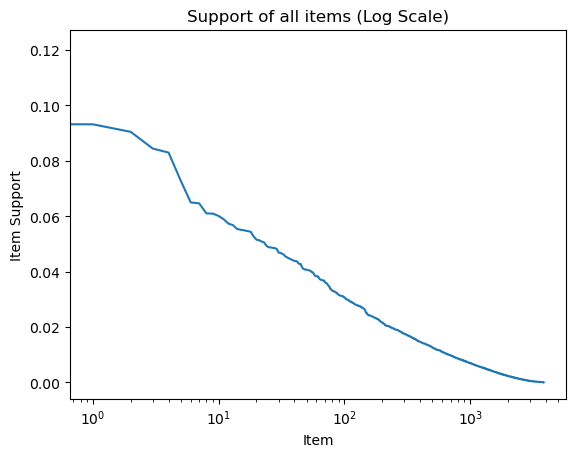

In [80]:
plt.plot(item_support.sort_values(ascending=False).values)
plt.xscale('log')
plt.xlabel('Item')
plt.ylabel('Item Support')
plt.title('Support of all items (Log Scale)')
plt.show()

## Find all frequent itemsets with minimum support greater than 0.025

In [81]:
min_support = 0.025
freq_itemsets_df = apriori(basket_filtered, min_support = min_support, use_colnames=True).sort_values('support', ascending = False)
freq_itemsets_df

,support,itemsets
140,0.121358,(WHITE HANGING HEART T-LIGHT HOLDER)
63,0.093197,(JUMBO BAG RED RETROSPOT)
113,0.090466,(REGENCY CAKESTAND 3 TIER)
9,0.084417,(ASSORTED COLOUR BIRD ORNAMENT)
99,0.082986,(PARTY BUNTING)
...,...,...
30,0.025689,(FELTCRAFT CUSHION OWL)
162,0.025559,"(LUNCH BAG SUKI DESIGN , LUNCH BAG BLACK SKULL.)"
44,0.025429,(HANGING HEART ZINC T-LIGHT HOLDER)
161,0.025299,"(LUNCH BAG SPACEBOY DESIGN , LUNCH BAG BLACK ..."


## Find all frequent two-itemsets

In [82]:
freq_two_itemsets = freq_itemsets_df[freq_itemsets_df['itemsets'].apply(lambda x: len(x))==2]
freq_two_itemsets

,support,itemsets
155,0.032908,"(JUMBO BAG RED RETROSPOT, JUMBO BAG PINK POLKA..."
160,0.031478,"(LUNCH BAG RED RETROSPOT, LUNCH BAG BLACK SKU..."
153,0.030957,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN..."
165,0.030632,"(LUNCH BAG RED RETROSPOT, LUNCH BAG PINK POLKA..."
151,0.029787,"(GARDENERS KNEELING PAD CUP OF TEA , GARDENERS..."
170,0.029787,"(WOODEN PICTURE FRAME WHITE FINISH, WOODEN FRA..."
150,0.029527,"(ALARM CLOCK BAKELIKE GREEN, ALARM CLOCK BAKEL..."
159,0.028746,"(LUNCH BAG PINK POLKADOT, LUNCH BAG BLACK SKU..."
168,0.028421,"(PAPER CHAIN KIT 50'S CHRISTMAS , PAPER CHAIN ..."
169,0.027836,"(RED HANGING HEART T-LIGHT HOLDER, WHITE HANGI..."


In [83]:
most_freq_two_itemset = set(freq_two_itemsets.iloc[0,1])
most_freq_two_itemset

{'JUMBO BAG PINK POLKADOT', 'JUMBO BAG RED RETROSPOT'}

### Compare apriori support calculation to manual support calculation for the most frequent itemset

In [84]:
count = 0
for ind, data in basket_filtered.iterrows():
    if most_freq_two_itemset.issubset(data[data].index):
        count += 1

print("Number of transactions with most frequent two itemset: \t", count)
print("Support of most frequent two itemset: \t\t\t", round(count/len(basket_filtered),5))
print("Support of most frequent two itemset from apriori: \t", round(freq_two_itemsets.iloc[0,0],5))

assert count/len(basket_filtered) == freq_two_itemsets.iloc[0,0]  

Number of transactions with most frequent two itemset: 	 506
Support of most frequent two itemset: 			 0.03291
Support of most frequent two itemset from apriori: 	 0.03291


### Reset frequent itemsets using a minimum support or 0.02

In [85]:
min_support = 0.02
freq_itemsets_df = apriori(basket_filtered, min_support = min_support, use_colnames=True).sort_values('support', ascending = False)
freq_itemsets_df

,support,itemsets
215,0.121358,(WHITE HANGING HEART T-LIGHT HOLDER)
92,0.093197,(JUMBO BAG RED RETROSPOT)
173,0.090466,(REGENCY CAKESTAND 3 TIER)
12,0.084417,(ASSORTED COLOUR BIRD ORNAMENT)
142,0.082986,(PARTY BUNTING)
...,...,...
22,0.020226,(CARD BILLBOARD FONT)
211,0.020161,(VINTAGE DOILY TRAVEL SEWING KIT)
230,0.020161,(ZINC FOLKART SLEIGH BELLS)
136,0.020031,(PANTRY MAGNETIC SHOPPING LIST)


## Generate association rules with a lift greater than 1

In [96]:
#Apply association rules
assoc_rules = association_rules(freq_itemsets_df, metric="lift", min_threshold=1).sort_values("lift",ascending=False).reset_index(drop=True)
assoc_rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.030957,0.031803,0.022177,0.716387,22.525889,0.021193,3.413792,0.986135
1,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.031803,0.030957,0.022177,0.697342,22.525889,0.021193,3.201769,0.986996
2,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",(GREEN REGENCY TEACUP AND SAUCER),0.024909,0.039802,0.022177,0.890339,22.369051,0.021186,8.756089,0.979699
3,(GREEN REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",0.039802,0.024909,0.022177,0.557190,22.369051,0.021186,2.202051,0.994894
4,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.031803,0.039802,0.026275,0.826176,20.756994,0.025009,5.523961,0.983088
5,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.039802,0.031803,0.026275,0.660131,20.756994,0.025009,2.848734,0.991279
6,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.030372,0.032908,0.020356,0.670236,20.366683,0.019357,2.932674,0.980686
7,(SPACEBOY LUNCH BOX ),(DOLLY GIRL LUNCH BOX),0.032908,0.030372,0.020356,0.618577,20.366683,0.019357,2.542133,0.983258
8,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.026275,0.043900,0.022177,0.844059,19.227048,0.021024,6.131184,0.973570
9,(ROSES REGENCY TEACUP AND SAUCER ),"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",0.043900,0.026275,0.022177,0.505185,19.227048,0.021024,1.967858,0.991517


In [88]:
assoc_rules[assoc_rules['consequents'].apply(lambda x: len(x))>=2]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.031803,0.030957,0.022177,0.697342,22.525889,0.021193,3.201769,0.986996
3,(GREEN REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",0.039802,0.024909,0.022177,0.557190,22.369051,0.021186,2.202051,0.994894
9,(ROSES REGENCY TEACUP AND SAUCER ),"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",0.043900,0.026275,0.022177,0.505185,19.227048,0.021024,1.967858,0.991517


In [89]:
assoc_rules[assoc_rules['antecedents'].apply(lambda x: len(x))>=2]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.030957,0.031803,0.022177,0.716387,22.525889,0.021193,3.413792,0.986135
2,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",(GREEN REGENCY TEACUP AND SAUCER),0.024909,0.039802,0.022177,0.890339,22.369051,0.021186,8.756089,0.979699
8,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.026275,0.043900,0.022177,0.844059,19.227048,0.021024,6.131184,0.973570


In [94]:
assoc_rules.sort_values("conviction",ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",(GREEN REGENCY TEACUP AND SAUCER),0.024909,0.039802,0.022177,0.890339,22.369051,0.021186,8.756089,0.979699
8,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.026275,0.043900,0.022177,0.844059,19.227048,0.021024,6.131184,0.973570
4,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.031803,0.039802,0.026275,0.826176,20.756994,0.025009,5.523961,0.983088
11,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.031803,0.043900,0.024909,0.783231,17.841424,0.023513,4.410690,0.974957
12,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.039802,0.043900,0.030957,0.777778,17.717202,0.029210,4.302452,0.982670
14,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.040713,0.048192,0.029787,0.731629,15.181557,0.027825,3.546618,0.973776
0,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.030957,0.031803,0.022177,0.716387,22.525889,0.021193,3.413792,0.986135
13,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.043900,0.039802,0.030957,0.705185,17.717202,0.029210,3.256952,0.986881
1,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.031803,0.030957,0.022177,0.697342,22.525889,0.021193,3.201769,0.986996
6,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.030372,0.032908,0.020356,0.670236,20.366683,0.019357,2.932674,0.980686


In [95]:
assoc_rules.sort_values("confidence",ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",(GREEN REGENCY TEACUP AND SAUCER),0.024909,0.039802,0.022177,0.890339,22.369051,0.021186,8.756089,0.979699
8,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.026275,0.043900,0.022177,0.844059,19.227048,0.021024,6.131184,0.973570
4,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.031803,0.039802,0.026275,0.826176,20.756994,0.025009,5.523961,0.983088
11,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.031803,0.043900,0.024909,0.783231,17.841424,0.023513,4.410690,0.974957
12,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.039802,0.043900,0.030957,0.777778,17.717202,0.029210,4.302452,0.982670
14,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.040713,0.048192,0.029787,0.731629,15.181557,0.027825,3.546618,0.973776
0,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.030957,0.031803,0.022177,0.716387,22.525889,0.021193,3.413792,0.986135
13,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.043900,0.039802,0.030957,0.705185,17.717202,0.029210,3.256952,0.986881
1,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.031803,0.030957,0.022177,0.697342,22.525889,0.021193,3.201769,0.986996
6,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.030372,0.032908,0.020356,0.670236,20.366683,0.019357,2.932674,0.980686


## Try again with a lower minimum support (from 0.02 to 0.01)

In [97]:
min_support = 0.01
freq_itemsets_df = apriori(basket_filtered, min_support = min_support, use_colnames=True).sort_values('support', ascending = False)
freq_itemsets_df

,support,itemsets
641,0.121358,(WHITE HANGING HEART T-LIGHT HOLDER)
278,0.093197,(JUMBO BAG RED RETROSPOT)
457,0.090466,(REGENCY CAKESTAND 3 TIER)
39,0.084417,(ASSORTED COLOUR BIRD ORNAMENT)
379,0.082986,(PARTY BUNTING)
...,...,...
350,0.010016,(PACK OF 12 SKULL TISSUES)
1073,0.010016,"(JUMBO BAG RED RETROSPOT, JUMBO BAG APPLES, JU..."
1074,0.010016,"(JUMBO BAG RED RETROSPOT, JUMBO BAG APPLES, JU..."
111,0.010016,(CHRISTMAS TOILET ROLL)


### See much higher lift

In [98]:
#Apply association rules
assoc_rules = association_rules(freq_itemsets_df, metric="lift", min_threshold=1).sort_values("lift",ascending=False).reset_index(drop=True)
assoc_rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(HERB MARKER ROSEMARY),"(HERB MARKER MINT, HERB MARKER THYME)",0.011772,0.010536,0.010146,0.861878,81.803970,0.010022,7.163720,0.999542
1,"(HERB MARKER MINT, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010536,0.011772,0.010146,0.962963,81.803970,0.010022,26.682167,0.998294
2,(HERB MARKER THYME),"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",0.011642,0.010796,0.010276,0.882682,81.759709,0.010150,8.431786,0.999404
3,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010796,0.011642,0.010276,0.951807,81.759709,0.010150,20.508438,0.998549
4,"(HERB MARKER PARSLEY, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010731,0.011772,0.010276,0.957576,81.346325,0.010149,23.293955,0.998421
5,(HERB MARKER ROSEMARY),"(HERB MARKER PARSLEY, HERB MARKER THYME)",0.011772,0.010731,0.010276,0.872928,81.346325,0.010149,7.785117,0.999472
6,"(HERB MARKER BASIL, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010536,0.011772,0.010081,0.956790,81.279585,0.009957,22.870429,0.998214
7,(HERB MARKER ROSEMARY),"(HERB MARKER BASIL, HERB MARKER THYME)",0.011772,0.010536,0.010081,0.856354,81.279585,0.009957,6.888192,0.999462
8,"(HERB MARKER BASIL, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010666,0.011642,0.010081,0.945122,81.185448,0.009956,18.010088,0.998331
9,(HERB MARKER THYME),"(HERB MARKER BASIL, HERB MARKER ROSEMARY)",0.011642,0.010666,0.010081,0.865922,81.185448,0.009956,7.378783,0.999316


In [99]:
assoc_rules.sort_values("conviction",ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1,"(HERB MARKER MINT, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010536,0.011772,0.010146,0.962963,81.803970,0.010022,26.682167,0.998294
4,"(HERB MARKER PARSLEY, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010731,0.011772,0.010276,0.957576,81.346325,0.010149,23.293955,0.998421
6,"(HERB MARKER BASIL, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010536,0.011772,0.010081,0.956790,81.279585,0.009957,22.870429,0.998214
3,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010796,0.011642,0.010276,0.951807,81.759709,0.010150,20.508438,0.998549
8,"(HERB MARKER BASIL, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010666,0.011642,0.010081,0.945122,81.185448,0.009956,18.010088,0.998331
16,"(HERB MARKER MINT, HERB MARKER PARSLEY)",(HERB MARKER ROSEMARY),0.010666,0.011772,0.010081,0.945122,80.288371,0.009955,18.007718,0.998192
18,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.011642,0.011772,0.010991,0.944134,80.204451,0.010854,17.689289,0.999164
12,"(HERB MARKER MINT, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010796,0.011642,0.010146,0.939759,80.724776,0.010020,16.406751,0.998391
10,"(HERB MARKER THYME, HERB MARKER ROSEMARY)",(HERB MARKER PARSLEY),0.010991,0.011576,0.010276,0.934911,80.759524,0.010149,15.185779,0.998593
15,"(HERB MARKER MINT, HERB MARKER ROSEMARY)",(HERB MARKER PARSLEY),0.010796,0.011576,0.010081,0.933735,80.657913,0.009956,14.916209,0.998381


In [100]:
assoc_rules.sort_values("confidence",ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1,"(HERB MARKER MINT, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010536,0.011772,0.010146,0.962963,81.803970,0.010022,26.682167,0.998294
4,"(HERB MARKER PARSLEY, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010731,0.011772,0.010276,0.957576,81.346325,0.010149,23.293955,0.998421
6,"(HERB MARKER BASIL, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.010536,0.011772,0.010081,0.956790,81.279585,0.009957,22.870429,0.998214
3,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010796,0.011642,0.010276,0.951807,81.759709,0.010150,20.508438,0.998549
16,"(HERB MARKER MINT, HERB MARKER PARSLEY)",(HERB MARKER ROSEMARY),0.010666,0.011772,0.010081,0.945122,80.288371,0.009955,18.007718,0.998192
8,"(HERB MARKER BASIL, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010666,0.011642,0.010081,0.945122,81.185448,0.009956,18.010088,0.998331
18,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.011642,0.011772,0.010991,0.944134,80.204451,0.010854,17.689289,0.999164
12,"(HERB MARKER MINT, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010796,0.011642,0.010146,0.939759,80.724776,0.010020,16.406751,0.998391
10,"(HERB MARKER THYME, HERB MARKER ROSEMARY)",(HERB MARKER PARSLEY),0.010991,0.011576,0.010276,0.934911,80.759524,0.010149,15.185779,0.998593
32,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER MINT),0.010796,0.011967,0.010081,0.933735,78.027763,0.009951,14.910321,0.997958
